# Modeling


In [1]:
import pickle
import seaborn as sns
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import os
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)


/home/wangruinju/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_training = pickle.load(open('my_df_training.pickle', 'rb'))
y = pickle.load(open('my_y.pickle', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(df_training, y)

In [3]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


def tuned_clf(estimator,k,Xtrain,ytrain,pram_dist,ncv,njobs=1,scoring_method='None',**kwargs):
    """K: the number of features in SelectKBest method
       Xtrain: training features
       ytrain: traning labels 
       param dist: distribution parametes that are used in RandomizedSearchCV
       ncv : number of cross-validation folds
       This function will return the trained estimator"""
    if kwargs:
        clf = estimator(kwargs)
    else:
        clf = estimator
    
    if k == Xtrain.shape[1]:
        pipe = make_pipeline(clf)
    else:
        pipe = make_pipeline(SelectKBest(k=k),clf)
    
    grid_clf = RandomizedSearchCV(pipe,param_distributions= param_dist,cv=ncv,n_jobs=njobs,scoring=scoring_method)
    grid_clf.fit(Xtrain,ytrain) 
                                  
    return  grid_clf

def tuned_estimators(estimator,Xtrain,ytrain,Xtest,ytest,param_dist,n_features_list,ncv=5,njobs=1,scoring_method='None',
                   verbose=False,**kwargs):
    '''A kbest and a randomforestclassifier are embeded in a pipeline and a randomizedsearchCV tunes the
     hyperparameters'''
    models = defaultdict(str)
    accuracy_scores = []
    f1_scores = []
    roc_auc_scores = []
    nfeatures = []
    for k in n_features_list:
        nfeatures.append(k)
        model_name = 'clf_k'+ str(k)
        clf = tuned_clf(estimator,k,Xtrain,ytrain,param_dist,ncv,njobs,scoring_method,**kwargs)
        models[model_name] = clf.best_estimator_
        ypred = models[model_name].predict(Xtest)
        accuracy_scores.append (accuracy_score(ypred,ytest))
        f1_scores.append(f1_score(ypred,ytest))
        roc_auc_scores.append(roc_auc_score(ypred,ytest))
        if verbose:
            print('%s best features: accuracy=%.4f, f1=%.4f, roc_auc=%.4f' % 
                  (k,accuracy_scores[-1],f1_scores[-1],roc_auc_scores[-1]))
    plt.title('Effect of feature elimination on accuracy, f1, roc_auc scores')
    plt.xlabel("K best features")
    plt.ylabel("Score")
    plt.xticks(nfeatures)
    plt.grid(b=True)
    plt.plot(nfeatures,accuracy_scores,'o-', color="r",label="accuracy score")
    plt.plot(nfeatures,f1_scores,'o-', color="b",label="f1 score")
    plt.plot(nfeatures,roc_auc_scores,'o-', color="g",label="roc_auc score")
    plt.legend(loc="best")
    return models

/home/wangruinju/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def Summary_Results(estimator,X_test,y_test):
    ypred = estimator.predict(X_test)
    print('The accuracy is: %.2f3 \n' % accuracy_score(ypred,y_test))
    print('Confusion_matrix:')
    cm = confusion_matrix(y_test, ypred)
    print('\t\t pridicted values')
    print('\t\t 0 \t 1')
    print('actual 0: ','\t',cm[0,0],'\t',cm[0,1])
    print('values 1: ','\t',cm[1,0],'\t',cm[1,1])
    print('-------------------------------------------------------')
    print('Classification_report: \n')
    print(classification_report(y_test,ypred,target_names=["class 0","class 1"]))

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def plot_roc_curve(estimator,Xtest,ytest,figsize=(8,5)):
    plt.figure(figsize=figsize)
    fpr_rf, tpr_rf, threshold = roc_curve(ytest,estimator.predict_proba(Xtest)[:,1])
    plt.plot(fpr_rf, tpr_rf)
    plt.xlabel('False positive rate',fontsize=16)
    plt.ylabel('True positive rate',fontsize=16)
    plt.title('ROC Curve',fontsize=18)


In [7]:
# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.metrics import classification_report_imbalanced
from collections import defaultdict

estimators = {'RandomForest':RandomForestClassifier(),'AdaBoost': AdaBoostClassifier(), 'Extra Tree': ExtraTreesClassifier()}
clfs = defaultdict(str)

for name,clf in estimators.items():
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(name + '_clf')
    print(classification_report_imbalanced(y_test, y_pred))
    clfs[name+'_clf'] = clf

Extra Tree_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.98      0.06      0.93      0.56      0.32     16015
          1       0.35      0.06      0.98      0.11      0.56      0.29      2231

avg / total       0.82      0.87      0.17      0.83      0.56      0.32     18246

AdaBoost_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      1.00      0.01      0.94      0.79      0.64     16015
          1       0.71      0.01      1.00      0.02      0.79      0.62      2231

avg / total       0.86      0.88      0.13      0.82      0.79      0.64     18246

RandomForest_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.99      0.06      0.93      0.62      0.40     16015
          1       0.44      0.06      0.99      0.10      0.62      0.37      2231

avg / total       0.83      0.88  

In [8]:
# undersample
from imblearn.under_sampling import RandomUnderSampler 

X_resampled, y_resampled = RandomUnderSampler().fit_sample(X_train, y_train)
for name,clf in estimators.items():
    clf.fit(X_resampled,y_resampled)
    y_pred = clf.predict(X_test)
    print(name + '_clf')
    print(classification_report_imbalanced(y_test, y_pred))
    clfs[name+'_undersample_clf'] = clf

Extra Tree_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.67      0.55      0.77      0.41      0.18     16015
          1       0.19      0.55      0.67      0.28      0.41      0.16      2231

avg / total       0.82      0.65      0.56      0.71      0.41      0.18     18246

AdaBoost_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.63      0.63      0.75      0.42      0.19     16015
          1       0.19      0.63      0.63      0.29      0.42      0.16      2231

avg / total       0.83      0.63      0.63      0.69      0.42      0.19     18246

RandomForest_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.68      0.57      0.78      0.43      0.20     16015
          1       0.20      0.57      0.68      0.29      0.43      0.17      2231

avg / total       0.83      0.67  

In [9]:
# oversample
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
for name,clf in estimators.items():
    clf.fit(X_resampled,y_resampled)
    y_pred = clf.predict(X_test)
    print(name + '_clf')
    print(classification_report_imbalanced(y_test, y_pred))
    clfs[name+'_oversample_clf'] = clf

Extra Tree_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.95      0.14      0.92      0.51      0.28     16015
          1       0.30      0.14      0.95      0.19      0.51      0.25      2231

avg / total       0.82      0.85      0.24      0.83      0.51      0.28     18246

AdaBoost_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.81      0.35      0.85      0.43      0.19     16015
          1       0.20      0.35      0.81      0.25      0.43      0.17      2231

avg / total       0.81      0.75      0.40      0.78      0.43      0.19     18246

RandomForest_clf
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.95      0.15      0.92      0.52      0.29     16015
          1       0.30      0.15      0.95      0.20      0.52      0.25      2231

avg / total       0.82      0.85  

In [10]:
for name,clf in clfs.items():
    print(name+':')
    Summary_Results(clfs[name],X_test.as_matrix(),y_test.as_matrix())
    print('================================================================')

RandomForest_oversample_clf:
The accuracy is: 0.853 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15274 	 741
values 1:  	 1907 	 324
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.95      0.92     16015
    class 1       0.30      0.15      0.20      2231

avg / total       0.82      0.85      0.83     18246

RandomForest_clf:
The accuracy is: 0.853 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15274 	 741
values 1:  	 1907 	 324
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.95      0.92     16015
    class 1       0.30      0.15      0.20      2231

avg / total       0.82      0.85      0.83     18246

Extra Tree_clf:
The accuracy is: 0.853 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15263 	 752
values

## RandomForestClassifier

10 best features: accuracy=0.8162, f1=0.2665, roc_auc=0.5791
15 best features: accuracy=0.8408, f1=0.2603, roc_auc=0.5988
20 best features: accuracy=0.8585, f1=0.2218, roc_auc=0.6150


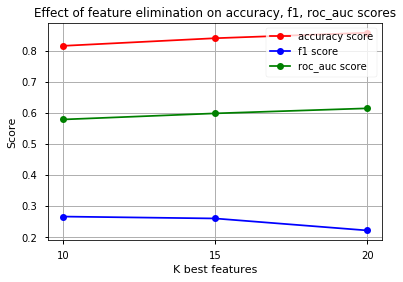

In [11]:
# the following all using regular method or oversampling method

# if has time to run
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind='regular')
X_train, y_train = smote.fit_sample(X_train, y_train)

# if has time to run
# from imblearn.combine import SMOTEENN
# X_train, y_train = SENN.fit_sample(X_train, y_train)

param_dist = {"randomforestclassifier__n_estimators": sp_randint(10,101),
              "randomforestclassifier__criterion": ["gini", "entropy"],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}
rseed = np.random.seed(22)

rf_args = {'random_state':rseed}
n_features_list = [10, 15, 20]
rf_clf = tuned_estimators(RandomForestClassifier, X_train, y_train, X_test, y_test, 
                          param_dist, n_features_list, ncv=5, njobs=5,
                          scoring_method='roc_auc',verbose=True,**rf_args)

In [12]:
Summary_Results(rf_clf['clf_k20'],X_test, y_test)

The accuracy is: 0.863 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15296 	 719
values 1:  	 1863 	 368
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.96      0.92     16015
    class 1       0.34      0.16      0.22      2231

avg / total       0.82      0.86      0.84     18246



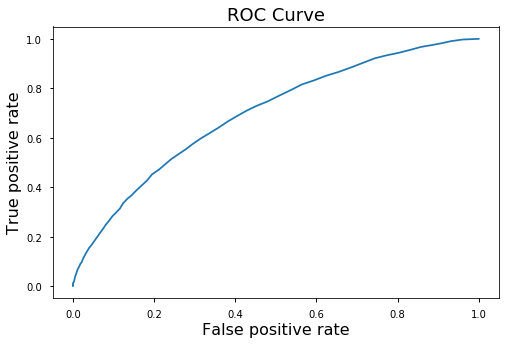

In [13]:
plot_roc_curve(rf_clf['clf_k20'], X_test, y_test)

## AdaBoost

10 best features: accuracy=0.7331, f1=0.2901, roc_auc=0.5621
15 best features: accuracy=0.7563, f1=0.2775, roc_auc=0.5608
20 best features: accuracy=0.7669, f1=0.2498, roc_auc=0.5515


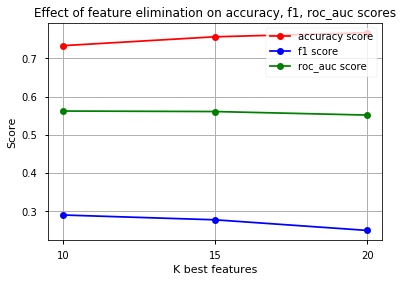

In [20]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001,0.001,0.01,0.1,1.0,2.0]}

n_features_list = [10, 15, 20]
clf = AdaBoostClassifier(random_state= rseed)

adb_clf = tuned_estimators(clf, X_train, y_train, X_test, y_test,  
                           param_dist, n_features_list, ncv=5, njobs=5,
                           scoring_method='roc_auc',verbose=True)

In [21]:
Summary_Results(adb_clf['clf_k20'], X_test, y_test)

The accuracy is: 0.773 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 13285 	 2730
values 1:  	 1523 	 708
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.90      0.83      0.86     16015
    class 1       0.21      0.32      0.25      2231

avg / total       0.81      0.77      0.79     18246



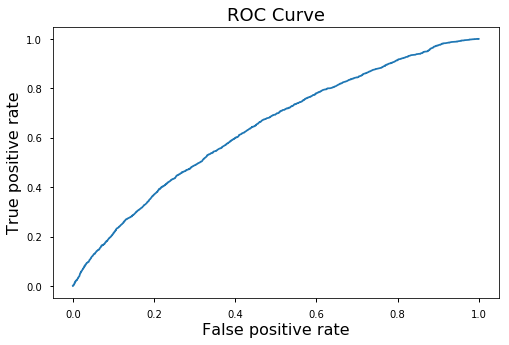

In [22]:
plot_roc_curve(adb_clf['clf_k20'], X_test, y_test)

#### Enforcing max depth = 5

10 best features: accuracy=0.7592, f1=0.2620, roc_auc=0.5548
15 best features: accuracy=0.8718, f1=0.1144, roc_auc=0.6258
20 best features: accuracy=0.8503, f1=0.2073, roc_auc=0.5920


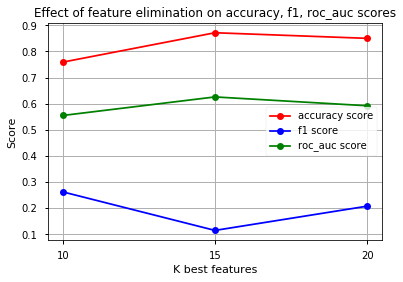

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

rseed = np.random.seed(22)

adaboost_args = {'random_state':rseed}
param_dist = {'adaboostclassifier__n_estimators': sp_randint(10,101), 
              'adaboostclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]}

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state= rseed),random_state= rseed)

n_features_list = [10, 15, 20]
adb_clf_depth5 = tuned_estimators(clf, X_train, y_train, X_test, y_test, 
                                  param_dist, n_features_list, ncv=5, njobs=6,
                                  scoring_method='roc_auc',verbose=True)

In [24]:
Summary_Results(adb_clf_depth5['clf_k20'], X_test, y_test)

The accuracy is: 0.853 

Confusion_matrix:
		 pridicted values
		 0 	 1
actual 0:  	 15158 	 857
values 1:  	 1874 	 357
-------------------------------------------------------
Classification_report: 

             precision    recall  f1-score   support

    class 0       0.89      0.95      0.92     16015
    class 1       0.29      0.16      0.21      2231

avg / total       0.82      0.85      0.83     18246



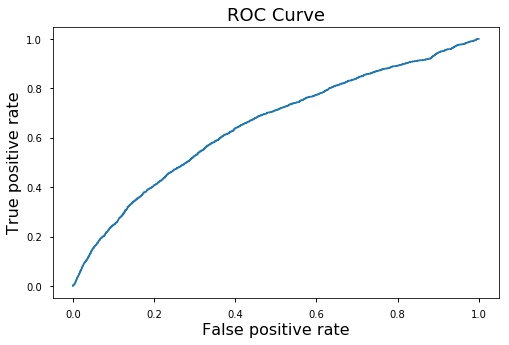

In [25]:
plot_roc_curve(adb_clf_depth5['clf_k20'], X_test, y_test)

## Ensemble Learning

In [39]:
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from copy import copy

def get_predictions(model, X):
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X)	
    else:
        pred = model.predict(X)

    if len(pred.shape) == 1:  # for 1-d ouputs
            pred = pred[:,None]

    return pred

class StackedGeneralizer(object):
    """Base class for stacked generalization classifier models
    """

    def __init__(self, base_models=None, blending_model=None, n_folds=5, verbose=True):
        """
        Stacked Generalizer Classifier

        Trains a series of base models using K-fold cross-validation, then combines
        the predictions of each model into a set of features that are used to train
        a high-level classifier model. 

        Parameters
        -----------
        base_models: list of classifier models
            Each model must have a .fit and .predict_proba/.predict method a'la
            sklearn
        blending_model: object
            A classifier model used to aggregate the outputs of the trained base
            models. Must have a .fit and .predict_proba/.predict method
        n_folds: int
            The number of K-folds to use in =cross-validated model training
        verbose: boolean

        Example
        -------

        from sklearn.datasets import load_digits
        from stacked_generalizer import StackedGeneralizer
        from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
        from sklearn.linear_model import LogisticRegression
        import numpy as np

        logger = Logger('test_stacked_generalizer')

        VERBOSE = True
        N_FOLDS = 5

        # load data and shuffle observations
        data = load_digits()

        X = data.data
        y = data.target

        shuffle_idx = np.random.permutation(y.size)

        X = X[shuffle_idx]
        y = y[shuffle_idx]

        # hold out 20 percent of data for testing accuracy
        n_train = round(X.shape[0]*.8)

        # define base models
        base_models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
                       RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
                       ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini')]

        # define blending model
        blending_model = LogisticRegression()

        # initialize multi-stage model
        sg = StackedGeneralizer(base_models, blending_model, 
                                n_folds=N_FOLDS, verbose=VERBOSE)

        # fit model
        sg.fit(X[:n_train],y[:n_train])

        # test accuracy
        pred = sg.predict(X[n_train:])
        pred_classes = [np.argmax(p) for p in pred]

        _ = sg.evaluate(y[n_train:], pred_classes)

                     precision    recall  f1-score   support

                  0       0.97      1.00      0.99        33
                  1       0.97      1.00      0.99        38
                  2       1.00      1.00      1.00        42
                  3       1.00      0.98      0.99        41
                  4       0.97      0.94      0.95        32
                  5       0.95      0.98      0.96        41
                  6       1.00      0.95      0.97        37
                  7       0.94      0.97      0.96        34
                  8       0.94      0.94      0.94        34
                  9       0.96      0.96      0.96        27

        avg / total       0.97      0.97      0.97       359
        """
        self.base_models = base_models
        self.blending_model = blending_model
        self.n_folds = n_folds
        self.verbose = verbose
        self.base_models_cv = None

    def fit_base_models(self, X, y):
        if self.verbose:
            print('Fitting Base Models...')

        kf = list(KFold(y.shape[0], self.n_folds))

        self.base_models_cv = {}

        for i, model in enumerate(self.base_models):

            model_name = "model %02d: %s" % (i+1, model.__repr__())
            if self.verbose:
                print('Fitting %s' % model_name)

            # run stratified CV for each model
            self.base_models_cv[model_name] = []			
            for j, (train_idx, test_idx) in enumerate(kf):
                if self.verbose:
                    print('Fold %d' % (j + 1))

                X_train = X[train_idx]
                y_train = y[train_idx]

                model.fit(X_train, y_train)

                # add trained model to list of CV'd models
                self.base_models_cv[model_name].append(copy(model))

    def transform_base_models(self, X):
        # predict via model averaging
        predictions = []
        for key in sorted(self.base_models_cv.keys()):
            cv_predictions = None
            n_models = len(self.base_models_cv[key])
            for i, model in enumerate(self.base_models_cv[key]):
                model_predictions = get_predictions(model, X)

                if cv_predictions is None:
                    cv_predictions = np.zeros((n_models, X.shape[0], model_predictions.shape[1]))

                cv_predictions[i,:,:] = model_predictions

            # perform model averaging and add to features
            predictions.append(cv_predictions.mean(0))

        # concat all features
        predictions = np.hstack(predictions)
        return predictions

    def fit_transform_base_models(self, X, y):
        self.fit_base_models(X, y)
        return self.transform_base_models(X)

    def fit_blending_model(self, X_blend, y):
        if self.verbose:
            model_name = "%s" % self.blending_model.__repr__()
            print('Fitting Blending Model:\n%s' % model_name)

        kf = list(KFold(y.shape[0], self.n_folds))
        # run  CV 
        self.blending_model_cv = []

        for j, (train_idx, test_idx) in enumerate(kf):
            if self.verbose:
                print('Fold %d' % j)

            X_train = X_blend[train_idx]
            y_train = y[train_idx]

            model = copy(self.blending_model)

            model.fit(X_train, y_train)

            # add trained model to list of CV'd models
            self.blending_model_cv.append(model)

    def transform_blending_model(self, X_blend):

        # make predictions from averaged models
        predictions = []
        n_models = len(self.blending_model_cv)
        for i, model in enumerate(self.blending_model_cv):
            cv_predictions = None
            model_predictions = get_predictions(model, X_blend)

            if cv_predictions is None:
                cv_predictions = np.zeros((n_models, X_blend.shape[0], model_predictions.shape[1]))

            cv_predictions[i,:,:] = model_predictions

        # perform model averaging to get predictions
        predictions = cv_predictions.mean(0)
        return predictions

    def predict(self, X):
        # perform model averaging to get predictions
        X_blend = self.transform_base_models(X)
        predictions = self.transform_blending_model(X_blend)

        return predictions

    def fit(self, X, y):
        X_blend = self.fit_transform_base_models(X, y)
        self.fit_blending_model(X_blend, y)

    def evaluate(self, y, y_pred):
        print(classification_report(y, y_pred))
        print('Confusion Matrix:')
        print(confusion_matrix(y, y_pred))
        return accuracy_score(y, y_pred)

In [44]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


base_models = [rf_clf['clf_k20'],
               adb_clf_depth5['clf_k20'],
               ExtraTreesClassifier(n_estimators=100, n_jobs=4, criterion='gini')]

blending_model = LogisticRegression()

sg = StackedGeneralizer(base_models, blending_model, n_folds=5, verbose=True)
sg.fit(X_train, y_train)

Fitting Base Models...
Fitting model 01: Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x7f9270cfc378>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decre...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fitting model 02: Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x7f9270cfc378>)), ('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=80, random_state=None))])
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fitting

In [45]:
pred = sg.predict(X_test)
pred_classes = [np.argmax(p) for p in pred]
_ = sg.evaluate(y_test, pred_classes)

             precision    recall  f1-score   support

          0       0.89      0.97      0.93     16015
          1       0.39      0.14      0.21      2231

avg / total       0.83      0.87      0.84     18246

Confusion Matrix:
[[15523   492]
 [ 1918   313]]
